In [1]:
import pandas as pd
import numpy as np
import random
from itertools import combinations
import copy
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore")

---
# 1. (30%) Statistical Process Control (Problem in 15.8.5)

EWMA control chart 的建置與計算在 MDS_Assignment4_r08725059.xlsx～

## (a) (5%) Construct an EWMA control chart with 𝜆 = 0.1. Use 𝐿 = 2.81. Does the process appear to be in control?

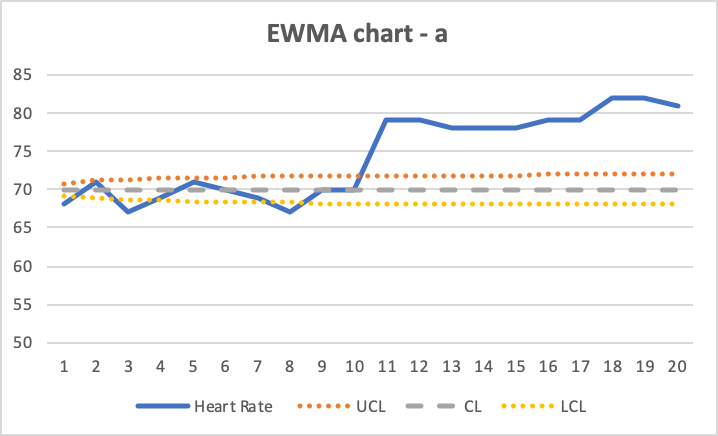

## (b) (5%) Construct an EWMA control chart with 𝜆 = 0.5. Use 𝐿 = 3.07. Compare your results to those in part (a).

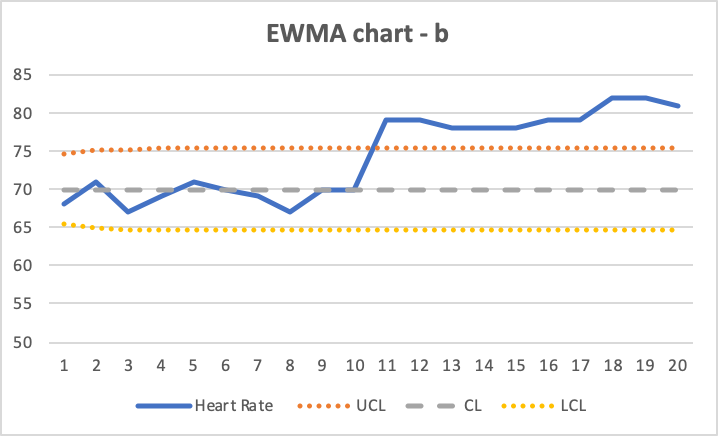

## (c) (5%) If the heart rate mean shifts to 76, approximate the ARLs for the charts in parts (a) and (b).

### 第一個 control chart

UCL（收斂逼近常態）= $\mu_0 + L\frac{\sigma}{\sqrt{n}}\sqrt{\frac{\lambda}{2-\lambda}}$ 

LCL（收斂逼近常態）= $\mu_0 - L\frac{\sigma}{\sqrt{n}}\sqrt{\frac{\lambda}{2-\lambda}}$ 

$V(Z_t) = \frac{\sigma^2}{n}\left( \frac{\lambda}{2-\lambda} \right)$

$\mu = 76, \mu_0 = 70, n=1$

$\Pr \left[ \frac{LCL-\mu}{\sqrt{V(Z_t)}} \leq Z \leq \frac{UCL-\mu}{\sqrt{V(Z_t)}} \right] = \Pr[-11.52779789, Z, -5.907797887] = 1.73356e^{-09}$

Out of control probability $p = 1-1.73356e^{-09} = 0.999999998$

ARL = $\frac{1}{p} = 1.000000002$

(計算附在 MDS_Assignment4_r08725059.xlsx)

### 第二個 control chart

UCL（收斂逼近常態）= $\mu_0 + L\frac{\sigma}{\sqrt{n}}\sqrt{\frac{\lambda}{2-\lambda}}$ 

LCL（收斂逼近常態）= $\mu_0 - L\frac{\sigma}{\sqrt{n}}\sqrt{\frac{\lambda}{2-\lambda}}$ 

$V(Z_t) = \frac{\sigma^2}{n}\left( \frac{\lambda}{2-\lambda} \right)$

$\mu = 76, \mu_0 = 70, n=1$

$\Pr \left[ \frac{LCL-\mu}{\sqrt{V(Z_t)}} \leq Z \leq \frac{UCL-\mu}{\sqrt{V(Z_t)}} \right] = \Pr[-6.534101615, Z, -0.394101615] = 0.346753009$

Out of control probability $p = 1-0.346753009 = 0.653246991$

ARL = $\frac{1}{p} = 1.530814553$

(計算附在 MDS_Assignment4_r08725059.xlsx)

## (d) (5%) What’s the probability that the control chart detects a shift to 76 on the first sample following the shift.

同上一小題的計算，此 probability 也就是 out of control probability，因此第一個control chart的 $p=0.999999998$，第二個 control chart的 $p=0.653246991$

## (e) (10%) What is the probability that the control chart does not detect a shift to 76 on the first sample following the shift, but does detect it on the second sample?

機率為 $p(1-p)$，第一個 control chart 為 1.73356E-09，第二個 control chart 為 0.22651536

---
# 2. (30%) Prognostics and Health Management (PHM)

## Load data

In [2]:
col_list = ['unit number', 'time, in cycles', 'operational setting 1', 'operational setting 2', 'operational setting 3']
for i in range(1,24):
    sensor_name = 'sensor measurement ' + str(i)
    col_list.append(sensor_name)

train_df = pd.read_csv('train.txt', sep=" ", names=col_list, index_col=False).dropna(axis='columns', how='all')

sensor_list = []
for i in range(1,22):
    sensor_name = 'sensor measurement ' + str(i)
    sensor_list.append(sensor_name)

Answer all the following questions with respect to unit number 1 (i.e. engine #1) ONLY for TRAINING dataset.

In [3]:
train_df = train_df[train_df['unit number'] == 1]
train_df

,unit number,"time, in cycles",operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,1,219,35.0073,0.8400,60.0,449.44,556.39,1381.50,1149.74,5.48,...,182.52,2388.11,8068.10,9.4265,0.02,337,2223,100.0,14.82,8.7966
219,1,220,35.0027,0.8400,60.0,449.44,556.65,1375.43,1149.45,5.48,...,182.73,2388.15,8068.06,9.4148,0.02,338,2223,100.0,14.75,8.8290
220,1,221,0.0008,0.0000,100.0,518.67,643.88,1593.26,1425.82,14.62,...,520.04,2388.28,8139.03,8.5363,0.03,394,2388,100.0,38.67,23.0218
221,1,222,20.0003,0.7001,0.0,491.19,608.00,1494.99,1270.18,9.35,...,313.64,2388.37,8065.53,9.2846,0.03,369,2324,100.0,24.28,14.5645


## (a) (5%) RUL Calculation: calculate remaining useful life (RUL) for each engine (different unit number) (hint: use the max time (in cycles) minus the current time, and create the remain useful life column). In fact, this is the task of “labelling” for supervised learning.

In [4]:
def calculate_RUL(df):
    df = copy.deepcopy(df)
    df['RUL'] = ''
    max_time = df.groupby(['unit number']).max()['time, in cycles']
    for i in range(df.shape[0]):
        df['RUL'][i] = max_time[df['unit number'][i]] - df['time, in cycles'][i]
    return df

In [5]:
train_df = calculate_RUL(train_df)

In [6]:
train_df

,unit number,"time, in cycles",operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,RUL
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,1,219,35.0073,0.8400,60.0,449.44,556.39,1381.50,1149.74,5.48,...,2388.11,8068.10,9.4265,0.02,337,2223,100.0,14.82,8.7966,4
219,1,220,35.0027,0.8400,60.0,449.44,556.65,1375.43,1149.45,5.48,...,2388.15,8068.06,9.4148,0.02,338,2223,100.0,14.75,8.8290,3
220,1,221,0.0008,0.0000,100.0,518.67,643.88,1593.26,1425.82,14.62,...,2388.28,8139.03,8.5363,0.03,394,2388,100.0,38.67,23.0218,2
221,1,222,20.0003,0.7001,0.0,491.19,608.00,1494.99,1270.18,9.35,...,2388.37,8065.53,9.2846,0.03,369,2324,100.0,24.28,14.5645,1


## (b) (5%) Variation Analysis: calculate the coefficient of variation (the ratio of the standard deviation to the mean) of each sensor. Which sensor shows maximum and minimum coefficient of variation, respectively? What’s the insight you can provide? (hint: variance implies information content)

In [7]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x)
sensor_cv = train_df[sensor_list].apply(cv)
print('minimum coefficient of variation:', sensor_cv.sort_values().index[0], sensor_cv.sort_values()[0])
print('maximum coefficient of variation:', sensor_cv.sort_values(ascending=False).index[0], sensor_cv.sort_values(ascending=False)[0])

minimum coefficient of variation: sensor measurement 14 0.011445721981227792
maximum coefficient of variation: sensor measurement 12 0.5291416815397664


## (c) (5%) Feature Engineering: feature engineering is used to derive more features for prediction. In time domain, calculate the “moving” average/ variance/ peak value (max value) of each sensor respectively, by using predetermined length of the time window (eg. In unit number 1: calculate (0 to 10), (1 to 11), (2 to 13)...if the time window equal to 11 cycles). You don’t need to consider the end of time series which does not have enough cycles in the window.

In [8]:
def moving_calculate(unit_df,  col_list, window_size):
    df = copy.deepcopy(unit_df)
    
    average_df = df[col_list].rolling(window_size, min_periods=1).mean()
    average_df = average_df.add_suffix('_average')
    variance_df = df[col_list].rolling(window_size, min_periods=1).var()
    variance_df = variance_df.add_suffix('_vaiance')
    max_df = df[col_list].rolling(window_size, min_periods=1).max()
    max_df = max_df.add_suffix('_max')
    
    all_feature_df = average_df.merge(variance_df, left_index=True, right_index=True).merge(max_df, left_index=True, right_index=True)
    
    return all_feature_df, average_df, variance_df, max_df

In [9]:
window_size = 10
all_feature_df, average_df, variance_df, max_df = moving_calculate(train_df, sensor_list, window_size)

all_feature_df

,sensor measurement 1_average,sensor measurement 2_average,sensor measurement 3_average,sensor measurement 4_average,sensor measurement 5_average,sensor measurement 6_average,sensor measurement 7_average,sensor measurement 8_average,sensor measurement 9_average,sensor measurement 10_average,...,sensor measurement 12_max,sensor measurement 13_max,sensor measurement 14_max,sensor measurement 15_max,sensor measurement 16_max,sensor measurement 17_max,sensor measurement 18_max,sensor measurement 19_max,sensor measurement 20_max,sensor measurement 21_max
0,489.0500,604.1300,1499.450000,1309.950,10.520000,15.490000,394.880,2318.870000,8770.200000,1.260000,...,372.15,2388.13,8120.83,8.6216,0.03,368.0,2319.0,100.0,28.58,17.1735
1,503.8600,623.1300,1542.000000,1356.955,12.570000,18.550000,474.275,2353.440000,8907.980000,1.280000,...,521.81,2388.15,8132.87,8.6216,0.03,391.0,2388.0,100.0,38.99,23.3619
2,485.7200,600.5600,1484.056667,1278.800,10.206667,15.033333,381.160,2309.913333,8719.956667,1.193333,...,521.81,2388.15,8132.87,9.3557,0.03,391.0,2388.0,100.0,38.99,23.3619
3,487.0875,602.1775,1485.152500,1271.395,9.992500,14.687500,369.575,2313.397500,8720.350000,1.165000,...,521.81,2388.15,8132.87,9.3557,0.03,391.0,2388.0,100.0,38.99,23.3619
4,478.6700,591.6460,1459.018000,1241.980,8.776000,12.892000,323.308,2293.078000,8639.192000,1.136000,...,521.81,2388.15,8132.87,9.3557,0.03,391.0,2388.0,100.0,38.99,23.3619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,462.2700,565.3740,1388.458000,1170.338,6.781000,9.676000,228.709,2185.903000,8391.350000,1.038000,...,520.08,2388.26,8134.63,11.0199,0.03,395.0,2388.0,100.0,38.50,23.0440
219,462.2700,565.3710,1388.199000,1170.377,6.781000,9.676000,228.746,2185.900000,8392.071000,1.038000,...,520.08,2388.26,8134.63,11.0199,0.03,395.0,2388.0,100.0,38.50,23.0440
220,462.2700,565.3620,1387.734000,1170.193,6.781000,9.676000,228.627,2185.899000,8393.238000,1.038000,...,520.04,2388.28,8139.03,11.0199,0.03,394.0,2388.0,100.0,38.67,23.0218
221,466.4450,570.5380,1399.655000,1182.690,7.168000,10.242000,242.579,2196.013000,8431.197000,1.043000,...,520.04,2388.37,8139.03,11.0199,0.03,394.0,2388.0,100.0,38.67,23.0218


## (d) (5%) Feature Selection 1: do the similar moving average work to RUL column, then calculate the correlation coefficients between each generated feature (i.e. average, variance, and max value) and RUL column. Identify the Top 10 features which have high absolute value of correlation coefficients with RUL.

In [10]:
all_RUL_df, average_RUL_df, variance_RUL_df, max_RUL_df = moving_calculate(train_df, ['RUL'], window_size)

average_RUL_df

,RUL_average
0,222.0
1,221.5
2,221.0
3,220.5
4,220.0
...,...
218,8.5
219,7.5
220,6.5
221,5.5


In [11]:
corr = all_feature_df.corrwith(average_RUL_df.RUL_average)
corr[corr.abs().sort_values(ascending=False)[:10].keys()]

sensor measurement 13_max       -0.823128
sensor measurement 21_average    0.313855
sensor measurement 20_average    0.311665
sensor measurement 10_average    0.308477
sensor measurement 7_average     0.307691
sensor measurement 12_average    0.307304
sensor measurement 5_average     0.306228
sensor measurement 21_vaiance    0.305694
sensor measurement 6_average     0.304381
sensor measurement 20_vaiance    0.303746
dtype: float64

## (e) (5%) Feature Selection 2: Use random forest and identify the Top 10 important features (i.e. average, variance, and max value) with respect to the RUL column. Plot the line plot which x axis is cycle and y axis is these 10 important features.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [16]:
df = all_feature_df.merge(train_df[['RUL', 'time, in cycles']], left_index=True, right_index=True)
df.set_index('time, in cycles', inplace=True)
df.dropna(axis='index', inplace=True)

X_train = df.drop(columns=['RUL'])    # variance 第一筆是空值，drop掉
y_train = df['RUL']

### Scoring function: weighted sum of RUL errors

In [18]:
def weighted_sum_RUL_eror(true_RUL, predict_RUL):
    for i in range(len(predict_RUL)):
        computed_score = 0
        rul_pred = predict_RUL[i]
        rul_true = true_RUL[i]
        d = rul_pred - rul_true
        a1 = 13
        a2 = 10
        if d < 0:
            computed_score += math.exp(-(d/a1))
        else:
            computed_score += math.exp((d/a2))
    return computed_score

### Tune Random Forest

In [19]:
score_dict = {}
depth = np.arange(1, 20)

best_score = 99999999
best_max_depth = 0

for i in depth:
    reg = RandomForestRegressor(max_depth = i, random_state=1)
    reg.fit(X_train, y_train)
    y_train_predict = reg.predict(X_train)
    score = weighted_sum_RUL_eror(y_train.to_numpy(), y_train_predict)
    score_dict[i] = score
    if score < best_score:
        best_score = score
        best_max_depth = i
        best_model = reg

print('best max depth:', best_max_depth, '; best score:', best_score)

best max depth: 8 ; best score: 1.1723379466807176


In [20]:
W = pd.Series(best_model.feature_importances_, X_train.columns)
top_ten_features = W[W.sort_values(ascending=False)[:10].keys()]
top_ten_features

sensor measurement 13_max    0.692514
sensor measurement 12_max    0.157284
sensor measurement 15_max    0.045198
sensor measurement 21_max    0.031098
sensor measurement 11_max    0.014895
sensor measurement 7_max     0.007370
sensor measurement 9_max     0.004011
sensor measurement 4_max     0.003661
sensor measurement 17_max    0.003649
sensor measurement 8_max     0.003578
dtype: float64

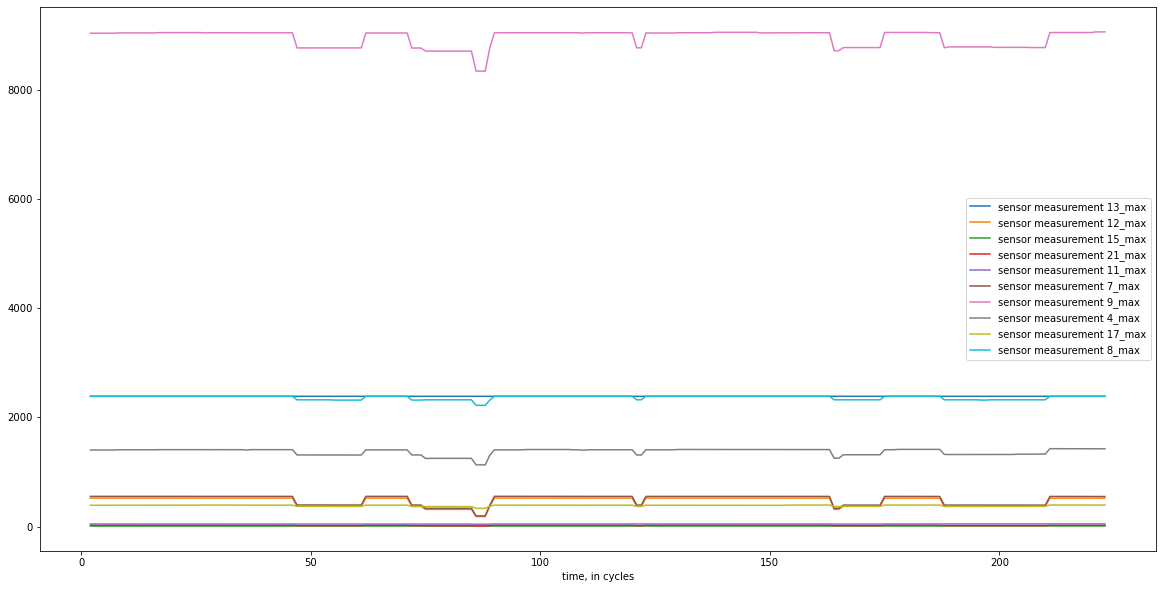

In [22]:
X_train[top_ten_features.keys()].plot.line(figsize=(20, 10))

---
# 3. Programming Questions (35%)
Please use Python to answer the following questions. Provide your code and justify your answer. Show all your work in detail including specific algorithm and parameter design. You should hand in TWO files (one for Tabu and one for Genetic Algorithm) regarding to each meta-heuristic algorithm, respectively. The result should include optimal solution (i.e., job sequence), optimal function (i.e. fitness) value, running time, number of tardy jobs. For the parameter settings (eg. tabu size, crossover rate, mutation rate, etc.), please give a simple trial-and-error or design of experiment for sensitivity analysis.

In [2]:
num_job = 20 # number of jobs

process_time = [10,10,13,4,9,4,8,15,7,1,9,3,15,9,11,6,5,14,18,3]
due_date = [50,38,49,12,20,105,73,45,6,64,15,6,92,43,78,21,15,50,150,99]
weight = [10,5,1,5,10,1,5,10,5,1,5,10,10,5,1,10,5,5,1,5]

instance_dict = {}

for i in range(num_job):
    jobs = i+1
    instance_dict[jobs] = {'process_time':process_time[i], 
                           'due_date':due_date[i], 
                           'weight':weight[i]}

In [3]:
def calculate_tardiness(instance_dict, job_sequence, show=False):
    total_tardiness = 0
    t = 0
    for job in job_sequence:
        C_i = t + instance_dict[job]['process_time']  # Completion time
        D_i = instance_dict[job]['due_date']      # due date of the job
        T_i = max(0, C_i - D_i)                   #tardiness for the job
        W_i = instance_dict[job]['weight']        # job's weight
        total_tardiness +=  W_i * T_i
        t = C_i
    
    if show:
        print('Total tardiness for {} solution schedule is: {}'.format(job_sequence ,total_tardiness))
        
    return total_tardiness

## (b) (15%) Develop Tabu Search (TS) algorithm to solve the problem. Show your design and the “result”.
根據老師上課投影片以及 Taylan 的 [medium 文章](https://medium.com/swlh/tabu-search-in-python-3199c44d44f1) 撰寫 TabuSearch 演算法

In [4]:
class TabuSearch():
    def __init__(self, instance_dict, tabu_size, seed, show=False):
        self.tabu_size = tabu_size
        self.instance_dict = instance_dict
        self.num_job = len(instance_dict)
        self.seed = seed
        self.show = show
        self.initial_solution = self.get_initial_solution()
        self.tabu_structure = self.get_initial_tabu_structure() # a dict of tabu attributes(pair of jobs that are swapped) as keys and [tabu_time, MoveValue]
    
    def get_initial_solution(self):
        initial_solution = list(range(1, (self.num_job+1)))
        random.seed(self.seed)
        random.shuffle(initial_solution)
        if self.show:
            print('Initial solution:', initial_solution)
        return initial_solution
    
    def get_initial_tabu_structure(self):
        tabu_structure = {}
        for swap in combinations(self.instance_dict.keys(), 2):
            tabu_structure[swap] = {'tabu_time': 0, 'move_value': 0}
        return tabu_structure
    
    def pair_swqp(self, solution, n1, n2):
        # returns a new neighbor solution with n1, n2 swapped
        solution = solution.copy()
        n1_index = solution.index(n1)
        n2_index = solution.index(n2)
        
        solution[n1_index], solution[n2_index] = solution[n2_index], solution[n1_index]
        return solution
    
    def tabu_search(self):
        best_solution = self.initial_solution
        best_objvalue = calculate_tardiness(self.instance_dict, best_solution, self.show)
        current_solution = self.initial_solution
        current_objvalue = calculate_tardiness(self.instance_dict, current_solution)
        
        iteration = 1
        Terminate = 0
        while Terminate < 100:
            if self.show:
                print('Iterations {}: Current_Objvalue: {}, Best_Objvalue: {}'.format(iteration, current_objvalue, best_objvalue))
            
            # Searching the whole neighborhood of the current solution:
            for move in self.tabu_structure:
                candidate_solution = self.pair_swqp(current_solution, move[0], move[1])
                candidate_objvalue = calculate_tardiness(self.instance_dict, candidate_solution, False)
                self.tabu_structure[move]['move_value'] = candidate_objvalue
            
            # Select best (the lowest tardiness/objvalue) from the non-tabu results
            while True:
                best_move = min(self.tabu_structure, key =lambda x: self.tabu_structure[x]['move_value'])
                move_value = self.tabu_structure[best_move]['move_value']
                tabu_time = self.tabu_structure[best_move]['tabu_time']
                
                # non-tabu
                if tabu_time < iteration:
                    current_solution = self.pair_swqp(current_solution, best_move[0], best_move[1])
                    current_objvalue = calculate_tardiness(self.instance_dict, current_solution)
                    
                    # Update lower tardiness
                    if move_value < best_objvalue:
                        best_solution = current_solution
                        best_objvalue = current_objvalue
                        Terminate = 0
                    else:
                        Terminate += 1
                        
                    # update tabu_time
                    self.tabu_structure[best_move]['tabu_time'] = iteration + self.tabu_size
                    iteration += 1
                    break
                
                # If tabu
                else:
                    if move_value < best_objvalue:
                        current_solution = self.pair_swqp(current_solution, best_move[0], best_move[1])
                        current_objvalue = calculate_tardiness(self.instance_dict, current_solution)
                        best_solution = current_solution
                        best_objvalue = current_objvalue
                        Terminate = 0
                        iteration += 1
                    else:
                        self.tabu_structure[best_move]['move_value'] = float('inf')
        
        if self.show:
            print('\n Performed iterations', iteration, 'Optimal solution:', best_solution, 'optimal tardiness/value:', best_objvalue)
        self.best_solution = best_solution
        self.best_objvalue = best_objvalue
        
        return self.best_solution, self.best_objvalue

### Try different initial sequence

In [5]:
tabu_size = 2
for s in range(43):
    test = TabuSearch(instance_dict, tabu_size, s)
    sol, objvalue = test.tabu_search()
    if s == 0:
        best_objvalue = objvalue
        best_seed = s
    elif objvalue < best_objvalue:
        best_objvalue = objvalue
        best_seed = s

test = TabuSearch(instance_dict, tabu_size, best_seed, True)
test.tabu_search()

Initial solution: [11, 19, 17, 15, 1, 18, 12, 3, 4, 10, 6, 8, 5, 20, 7, 16, 9, 2, 14, 13]
Total tardiness for [11, 19, 17, 15, 1, 18, 12, 3, 4, 10, 6, 8, 5, 20, 7, 16, 9, 2, 14, 13] solution schedule is: 6973
Iterations 1: Current_Objvalue: 6973, Best_Objvalue: 6973
Iterations 2: Current_Objvalue: 5139, Best_Objvalue: 5139
Iterations 3: Current_Objvalue: 4351, Best_Objvalue: 4351
Iterations 4: Current_Objvalue: 3720, Best_Objvalue: 3720
Iterations 5: Current_Objvalue: 3325, Best_Objvalue: 3325
Iterations 6: Current_Objvalue: 3051, Best_Objvalue: 3051
Iterations 7: Current_Objvalue: 2753, Best_Objvalue: 2753
Iterations 8: Current_Objvalue: 2513, Best_Objvalue: 2513
Iterations 9: Current_Objvalue: 2313, Best_Objvalue: 2313
Iterations 10: Current_Objvalue: 2168, Best_Objvalue: 2168
Iterations 11: Current_Objvalue: 2056, Best_Objvalue: 2056
Iterations 12: Current_Objvalue: 2006, Best_Objvalue: 2006
Iterations 13: Current_Objvalue: 1971, Best_Objvalue: 1971
Iterations 14: Current_Objvalue: 

([12, 4, 17, 5, 16, 9, 8, 1, 11, 10, 7, 13, 20, 14, 2, 18, 6, 15, 3, 19], 1928)

### Find best tabu size

In [6]:
for size in range(1, 11):
    test = TabuSearch(instance_dict, size, best_seed)
    sol, objvalue = test.tabu_search()
    if size == 1:
        best_objvalue = objvalue
        best_size = size
    elif objvalue < best_objvalue:
        best_objvalue = objvalue
        best_size = size

test = TabuSearch(instance_dict, best_size, best_seed, True)
test.tabu_search()

Initial solution: [11, 19, 17, 15, 1, 18, 12, 3, 4, 10, 6, 8, 5, 20, 7, 16, 9, 2, 14, 13]
Total tardiness for [11, 19, 17, 15, 1, 18, 12, 3, 4, 10, 6, 8, 5, 20, 7, 16, 9, 2, 14, 13] solution schedule is: 6973
Iterations 1: Current_Objvalue: 6973, Best_Objvalue: 6973
Iterations 2: Current_Objvalue: 5139, Best_Objvalue: 5139
Iterations 3: Current_Objvalue: 4351, Best_Objvalue: 4351
Iterations 4: Current_Objvalue: 3720, Best_Objvalue: 3720
Iterations 5: Current_Objvalue: 3325, Best_Objvalue: 3325
Iterations 6: Current_Objvalue: 3051, Best_Objvalue: 3051
Iterations 7: Current_Objvalue: 2753, Best_Objvalue: 2753
Iterations 8: Current_Objvalue: 2513, Best_Objvalue: 2513
Iterations 9: Current_Objvalue: 2313, Best_Objvalue: 2313
Iterations 10: Current_Objvalue: 2168, Best_Objvalue: 2168
Iterations 11: Current_Objvalue: 2056, Best_Objvalue: 2056
Iterations 12: Current_Objvalue: 2006, Best_Objvalue: 2006
Iterations 13: Current_Objvalue: 1971, Best_Objvalue: 1971
Iterations 14: Current_Objvalue: 

([12, 4, 17, 5, 16, 9, 8, 1, 11, 10, 7, 13, 20, 14, 2, 18, 6, 15, 3, 19], 1928)

## (c) (15%) Develop Genetic Algorithm (GA) to solve the problem. Show your design and the “result”.

參考 [PO Lab](https://github.com/wurmen/Genetic-Algorithm-for-Job-Shop-Scheduling-and-NSGA-II) 的 GA 演算法介紹撰寫以下 GA 演算法


In [12]:
class GeneticAlgorithm():
    def __init__(self, instance_dict, population_size, show=False):
        self.instance_dict = instance_dict
        self.num_job = len(instance_dict)
        self.show = show
        self.population_size = population_size        
        self.population_list = self.get_population_list()
        self.best_objvalue = 999999999999
        self.best_solution = []
        
    def get_population_list(self):
        population_list = []
        for i in range(self.population_size):
            initial_solution = list(range(1, (self.num_job+1)))
            random.shuffle(initial_solution)
            population_list.append(initial_solution)
        return population_list
    
    def crossover(self, crossover_rate):
        self.parent_list = copy.deepcopy(self.population_list)
        self.offspring_list = copy.deepcopy(self.population_list)
        self.crossover_rate = crossover_rate
        
        S = list(np.random.permutation(self.population_size))
        for m in range(int(self.population_size/2)):
            crossover_prob = np.random.rand()
            if self.crossover_rate < crossover_prob:
                continue
            parent_1 = self.parent_list[S[2*m]][:]
            parent_2 = self.parent_list[S[2*m+1]][:]
            child_1 = ['na' for i in range(self.num_job)]
            child_2 = ['na' for i in range(self.num_job)]
            
            fix_num = int(round(num_job/2))
            fix_jobs = list(np.random.choice(self.num_job, fix_num, replace=False))
            for fix_j in fix_jobs:
                child_1[fix_j] = parent_2[fix_j]
                child_2[fix_j] = parent_1[fix_j]
            c1 = [p1 for p1 in parent_1 if p1 not in child_1]
            c2 = [p2 for p2 in parent_2 if p2 not in child_2]
            
            for i in range(self.num_job-fix_num):
                child_1[child_1.index('na')] = c1[i]
                child_2[child_2.index('na')] = c2[i]
                
            self.offspring_list[S[2*m]] = child_1[:]
            self.offspring_list[S[2*m+1]]=child_2[:]
            
    def mutation(self, mutation_rate, mutation_selection_rate):
        self.mutation_rate = mutation_rate
        self.mutation_selection_rate = mutation_selection_rate
        num_mutation_jobs = int(round(self.num_job * mutation_selection_rate))
        
        for m in range(len(self.offspring_list)):
            mutation_prob = np.random.rand()
            if mutation_rate < mutation_prob:
                continue
            mutation_position_list = list(np.random.choice(self.num_job, num_mutation_jobs, replace=False))
            mutation_value_first = self.offspring_list[m][mutation_position_list[0]]
            for i in range(num_mutation_jobs-1):
                self.offspring_list[m][mutation_position_list[i]]=self.offspring_list[m][mutation_position_list[i+1]]
            self.offspring_list[m][mutation_position_list[num_mutation_jobs-1]] = mutation_value_first
            
    def get_fitness_value(self):
        self.total_chromosome=copy.deepcopy(self.parent_list)+copy.deepcopy(self.offspring_list)
        self.chrom_fitness = []
        self.chrom_fit = []    #總加權延遲
        self.total_fitness = 0
        for i in range(self.population_size*2):
            tardiness = calculate_tardiness(self.instance_dict, self.total_chromosome[i], show=False)
            self.chrom_fitness.append(1/tardiness)
            self.chrom_fit.append(tardiness)
            self.total_fitness += self.chrom_fitness[i]
    
    def selection(self):
        pk, qk = [], []
        for i in range(self.population_size*2):
            pk.append(self.chrom_fitness[i]/self.total_fitness)
        for i in range(self.population_size*2):
            cumulative = 0
            for j in range(0,i+1):
                cumulative += pk[j]
            qk.append(cumulative)
            
        selection_rand = [np.random.rand() for i in range(self.population_size)]
        
        for i in range(self.population_size):
            if selection_rand[i] <= qk[0]:
                self.population_list[i]=copy.deepcopy(self.total_chromosome[0])
            else:
                for j in range(0, self.population_size*2-1):
                    if selection_rand[i] > qk[j] and selection_rand[i] <= qk[j+1]:
                        self.population_list[i]=copy.deepcopy(self.total_chromosome[j+1])
                        break
    
    def comparison(self, objvalue_now):
        for i in range(self.population_size*2):
            if self.chrom_fit[i] < objvalue_now:
                objvalue_now = self.chrom_fit[i]
                solution_now = copy.deepcopy(self.total_chromosome[i])
        if objvalue_now < self.best_objvalue:
            self.best_objvalue = objvalue_now
            self.best_solution = copy.deepcopy(solution_now)
    
    def GA_search(self, num_iteration, crossover_rate, mutation_rate, mutation_selection_rate):
        best_list,best_obj=[],[]
        for n in range(num_iteration):
            objvalue_now = self.best_objvalue
            self.crossover(crossover_rate)
            self.mutation(mutation_rate, mutation_selection_rate)
            self.get_fitness_value()
            self.selection()
            self.comparison(objvalue_now)
        
        if self.show:
            print('Optimal solution:', self.best_solution, 'optimal tardiness/value:', self.best_objvalue)
        
        return self.best_solution, self.best_objvalue

In [17]:
population_size = 30
crossover_rate = 0.5
mutation_rate = 0.1
mutation_selection_rate = 0.5
num_iteration = 100

GA_test = GeneticAlgorithm(instance_dict, population_size, show=True)
GA_test.GA_search(num_iteration, crossover_rate, mutation_rate, mutation_selection_rate)

Optimal solution: [17, 12, 5, 4, 16, 9, 8, 1, 11, 18, 13, 20, 6, 2, 3, 14, 10, 15, 7, 19] optimal tardiness/value: 2380


([17, 12, 5, 4, 16, 9, 8, 1, 11, 18, 13, 20, 6, 2, 3, 14, 10, 15, 7, 19], 2380)

### Find the best crossover rate, nutation rate, mutation selection rate

In [18]:
population_size = 30
num_iteration = 100

optimal_objvalue = 999999999
optimal_solution = []

for crossover_rate in np.arange(0, 1, 0.1):
    for mutation_rate in np.arange(0, 1, 0.1):
        for mutation_selection_rate in np.arange(0.1, 1, 0.1):
            if mutation_rate == 0:
                mutation_selection_rate = 0
            print('========')
            print('crossover rate:', crossover_rate, 'mutation rate', mutation_rate, 'mutation selection rate:', mutation_selection_rate)
            GA_test = GeneticAlgorithm(instance_dict, population_size, show=True)
            solution, objvalue = GA_test.GA_search(num_iteration, crossover_rate, mutation_rate, mutation_selection_rate)
            if objvalue < optimal_objvalue:
                optimal_objvalue = objvalue
                optimal_solution = solution
                
            if mutation_rate == 0:
                break

print('\n Optimal solution:', optimal_solution, 'optimal tardiness/value:', optimal_objvalue)

crossover rate: 0.0 mutation rate 0.0 mutation selection rate: 0
Optimal solution: [5, 2, 10, 12, 18, 17, 7, 6, 20, 9, 16, 1, 11, 8, 4, 13, 3, 19, 15, 14] optimal tardiness/value: 3968
crossover rate: 0.0 mutation rate 0.1 mutation selection rate: 0.1
Optimal solution: [16, 12, 5, 8, 1, 20, 18, 7, 11, 15, 17, 14, 9, 4, 6, 13, 10, 3, 2, 19] optimal tardiness/value: 3297
crossover rate: 0.0 mutation rate 0.1 mutation selection rate: 0.2
Optimal solution: [9, 4, 5, 17, 12, 16, 8, 1, 7, 11, 10, 13, 18, 15, 14, 6, 20, 2, 3, 19] optimal tardiness/value: 2438
crossover rate: 0.0 mutation rate 0.1 mutation selection rate: 0.30000000000000004
Optimal solution: [16, 9, 17, 10, 5, 14, 1, 12, 7, 11, 4, 20, 8, 13, 19, 15, 18, 3, 6, 2] optimal tardiness/value: 3075
crossover rate: 0.0 mutation rate 0.1 mutation selection rate: 0.4
Optimal solution: [10, 5, 7, 4, 9, 8, 17, 16, 12, 11, 14, 20, 15, 1, 2, 19, 13, 18, 3, 6] optimal tardiness/value: 3727
crossover rate: 0.0 mutation rate 0.1 mutation sele

## (d) (5%) Please give a comparison between Tabu and GA. You may try different parameters to see the change of the results (i.e., sensitivity analysis) in your developed algorithm. What’s the “insight” or interesting things you found?

前面在建置各演算法的 result 時，已嘗試不同 parameter 建置，在此直接比較兩者的結果。

首先單看最終結果，Tabu search 的結果比 GA 的結果好，但兩者的 optimal values 相差沒有很大。其可能原因為 GA search 的 crossover、mutation、selection 等較具有隨機性。